In [1]:

import sklearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import VotingClassifier
import sys
#sys.path.append('178-hw4-code')
import mltools as ml

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_curve, auc


In [2]:
X = np.genfromtxt('data/X_train.txt', delimiter=',')
Y = np.genfromtxt('data/Y_train.txt', delimiter=',')

# The test data
Xte = np.genfromtxt('data/X_test.txt', delimiter=',')

In [3]:
Xtr, Xva, Ytr, Yva = ml.splitData(X, Y)
Xtr, Ytr = ml.shuffleData(Xtr, Ytr)

# Taking a subsample of the data so that trains faster.  You should train on whole data for homework and Kaggle.


In [4]:
learner = ml.dtree.treeClassify(X, Y, maxDepth = 9 ,minParent= 2**9)
Ydt = learner.predictSoft(Xte)

Ydt = Ydt[:,1]

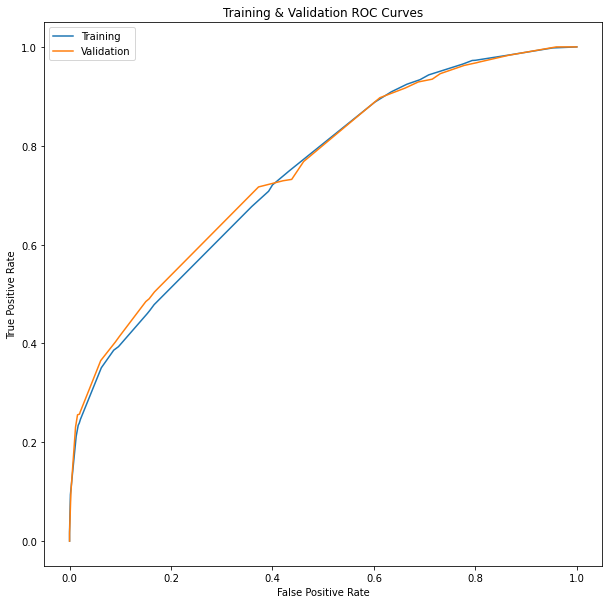

Training AUC: 0.7487025273984623
Validation AUC: 0.7584104938271605


In [5]:
fprTr, tprTr, _ = learner.roc(Xtr, Ytr)
fprVa, tprVa, _ = learner.roc(Xva, Yva)


_, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(fprTr, tprTr, label='Training')
ax.plot(fprVa, tprVa, label='Validation')
ax.set_title("Training & Validation ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

ax.legend()
plt.show()

print('Training AUC:', learner.auc(Xtr, Ytr))
print('Validation AUC:', learner.auc(Xva, Yva))

In [6]:
Xte = np.genfromtxt('data/X_test.txt', delimiter=',')
Yte = np.vstack((np.arange(Xte.shape[0]), learner.predictSoft(Xte)[:,1])).T # Output a file with two columns, a row ID and a confidence in class 1:
np.savetxt('Y_submit.txt',Yte,'%d, %.2f',header='Id,Predicted',comments='',delimiter=',')


In [14]:
np.random.seed(0)
mtr,ntr=Xtr.shape
mva,nva=Xva.shape
mte,nte=Xte.shape 
nBag = 20
classifiers = [None] * nBag
YtrPredict = np.zeros((mtr, nBag))
YvaPredict = np.zeros((mva, nBag))
re = np.zeros((Xte.shape[0],1))
tr_err=[]
va_err=[]
for i in range(nBag):
    Xi, Yi = ml.bootstrapData(X,Y)
    classifiers[i] = ml.dtree.treeClassify(Xi,Yi,maxDepth=15,nFeatures=50,minLeaf=4,minParent = 1024)
    YtrPredict[:,i] = classifiers[i].predict(Xtr)
    YvaPredict[:,i]= classifiers[i].predict(Xva)
    re =re+classifiers[i].predictSoft(Xte)

re = re/20
re = re[:,1]

In [15]:
gbc = GradientBoostingClassifier(random_state=0, n_estimators=250, min_samples_split=10, min_samples_leaf=30, max_features=20, learning_rate=0.05)
gbc.fit(X, Y)

Y_pred = gbc.predict_proba(Xte)[:,1]




In [24]:
Yte =np.zeros((Xte.shape[0],1))
for i in range(Xte.shape[0]):
    batch = 0
    d1 = abs(Ydt[i] - Y_pred[i])
    d2 = abs(Ydt[i] - re[i])
    d3 = abs(Y_pred[i] - re[i])
    m = min([d1, d2, d3])
    if m == d1:
        batch += 1.2 * Ydt[i]
        batch += 1.2 * Y_pred[i]
        batch += 0.6 * re[i]
    elif m == d2:  
        batch += 1.2 * Ydt[i]
        batch += 0.6 * Y_pred[i]
        batch += 1.2 * re[i]
    else:  
        batch += 0.6 * Ydt[i]
        batch += 1.2 * Y_pred[i]
        batch += 1.2 * re[i]
         
    batch = batch/3
    Yte[i] = batch

In [25]:
Xte = np.genfromtxt('data/X_test.txt', delimiter=',')
Yte = np.vstack((np.arange(Xte.shape[0]), Yte[:,0])).T # Output a file with two columns, a row ID and a confidence in class 1:
np.savetxt('Y_submitEnsemble6.txt',Yte,'%d, %.2f',header='Id,Predicted',comments='',delimiter=',')


In [204]:
Yte[:,0]

array([0.42337874, 0.19016114, 0.51225433, ..., 0.4812444 , 0.91382641,
       0.43891696])

In [195]:
Yhat = gbc.predict_proba(Xva)

false_positive_rate, true_positive_rate, thresholds = roc_curve(Yva, Yhat[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)


0.7430283224400871


(7422,)

In [153]:
knn = KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=1,
           weights='uniform')
knn.fit(Xtr,Ytr) 

KNeighborsClassifier(n_jobs=1, p=1)

In [156]:
KNNPred = knn.predict_proba(Xtr)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Ytr,KNNPred[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.7642825223545792


In [157]:
KNNPred = knn.predict_proba(Xva)
false_positive_rate, true_positive_rate, thresholds = roc_curve(Yva,KNNPred[:,1])
roc_auc = auc(false_positive_rate, true_positive_rate)
print(roc_auc)

0.5422285766158316


In [158]:
Xte = np.genfromtxt('178-hw4-code/data/X_test.txt', delimiter=',')
Yte = np.vstack((np.arange(Xte.shape[0]), knn.predict_proba(Xte)[:,1])).T # Output a file with two columns, a row ID and a confidence in class 1:
np.savetxt('Y_submit.txt',Yte,'%d, %.2f',header='Id,Predicted',comments='',delimiter=',')



In [132]:
nn = ml.nnet.nnetClassify()

In [133]:
nn.init_weights([Xt.shape[1], 200, 200, len(np.unique(Yt))], 'random', Xt, Yt)

In [134]:
#nn.train(Xt, Yt, stopTol=1e-8, initStep=.25, stopIter=50)

In [135]:
#sig = lambda z: z if z > 0 else 0
#dsig = lambda z: 1 if z > 0 else 0

# outter changed to ReLu
nn.setActivation('logistic')

In [143]:
nn.train(Xt, Yt, stopTol=1e-8, initStep=.25, stopIter=10000)


it 2 : Jsur = 0.5008310219333599, J01 = 0.5035
it 4 : Jsur = 0.5026161280621965, J01 = 0.5035
it 8 : Jsur = 0.5006828230179489, J01 = 0.5035
it 16 : Jsur = 0.5000205514731556, J01 = 0.5035
it 32 : Jsur = 0.5004814452242639, J01 = 0.5035
it 64 : Jsur = 0.5001914290001824, J01 = 0.5035
it 128 : Jsur = 0.501009364890755, J01 = 0.5035
it 256 : Jsur = 0.5002066058161693, J01 = 0.4965
it 512 : Jsur = 0.5020613919877677, J01 = 0.4965
it 1024 : Jsur = 0.5007001051199236, J01 = 0.4965
it 2048 : Jsur = 0.4999909739948723, J01 = 0.4965
it 4096 : Jsur = 0.5000207739639624, J01 = 0.50225
it 8192 : Jsur = 0.4999785371715215, J01 = 0.4965


AttributeError: 'nnetClassify' object has no attribute 'Jsur'

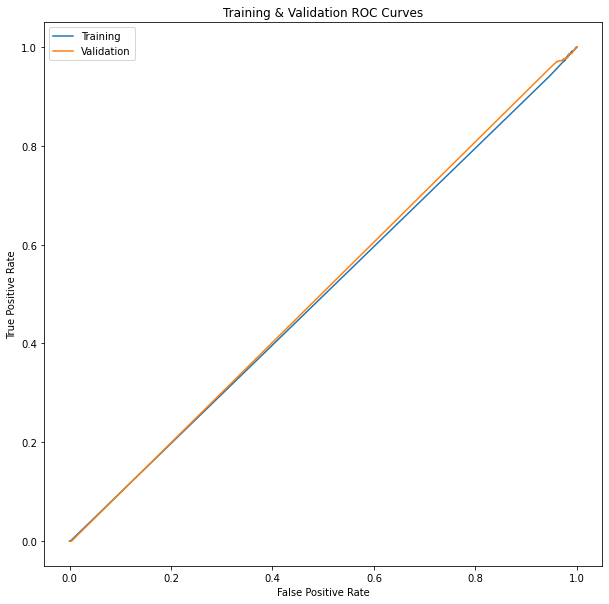

Training AUC: 0.4992344551454586
Validation AUC: 0.5024446259985476


In [137]:
fprTr, tprTr, _ = nn.roc(Xtr, Ytr)
fprVa, tprVa, _ = nn.roc(Xva, Yva)

_, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(fprTr, tprTr, label='Training')
ax.plot(fprVa, tprVa, label='Validation')
ax.set_title("Training & Validation ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

ax.legend()
plt.show()

print('Training AUC:', nn.auc(Xtr, Ytr))
print('Validation AUC:', nn.auc(Xva, Yva))

In [31]:
Xte = np.genfromtxt('178-hw4-code/data/X_test.txt', delimiter=',')
Yte = np.vstack((np.arange(Xte.shape[0]), nn.predictSoft(Xte)[:,1])).T # Output a file with two columns, a row ID and a confidence in class 1:
np.savetxt('Y_submit.txt',Yte,'%d, %.2f',header='Id,Predicted',comments='',delimiter=',')


In [144]:
random_forest_classifier = ensemble.RandomForestClassifier(
    n_estimators=1000, min_samples_leaf=4, n_jobs=-1, oob_score=True)

print("training started")
starting_time = time.time()
random_forest_classifier.fit(x_train, y_train)
end_time = time.time()
print("training finished, took {} seconds".format(end_time - starting_time))

random_forest_classifier_roc = metrics.roc_auc_score(
    y_validation, random_forest_classifier.predict_proba(x_validation)[:,1])
print(random_forest_classifier_roc)

print("training error:", 1 - random_forest_classifier.score(x_train, y_train))
print("validation error:", 1 - random_forest_classifier.score(x_validation, y_validation))

NameError: name 'ensemble' is not defined

In [ ]:

fprTr, tprTr, _ = learner.roc(Xtr, Ytr)
fprVa, tprVa, _ = learner.roc(Xva, Yva)


_, ax = plt.subplots(1, 1, figsize=(10,10))
ax.plot(fprTr, tprTr, label='Training')
ax.plot(fprVa, tprVa, label='Validation')
ax.set_title("Training & Validation ROC Curves")
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

ax.legend()
plt.show()

print('Training AUC:', learner.auc(Xtr, Ytr))
print('Validation AUC:', learner.auc(Xva, Yva))